In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import scipy.stats as stats
from collections import Counter

Import data

In [2]:
raw = pd.read_csv('int20h-ds-test-dataset.csv')
raw['event_created_date'] = pd.to_datetime(raw['event_created_date'])
data = raw.copy()
data.set_index('userid', inplace=True)

Check for missing values

<AxesSubplot:ylabel='userid'>

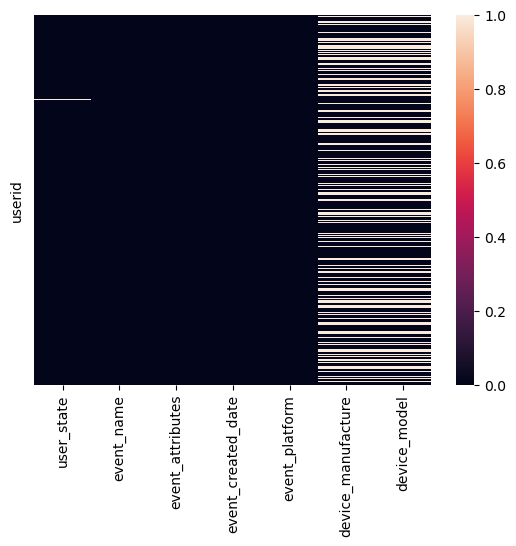

In [3]:
sns.heatmap(data.isnull(), yticklabels = False)

is missing values in devices connected with subscription?

<AxesSubplot:ylabel='userid'>

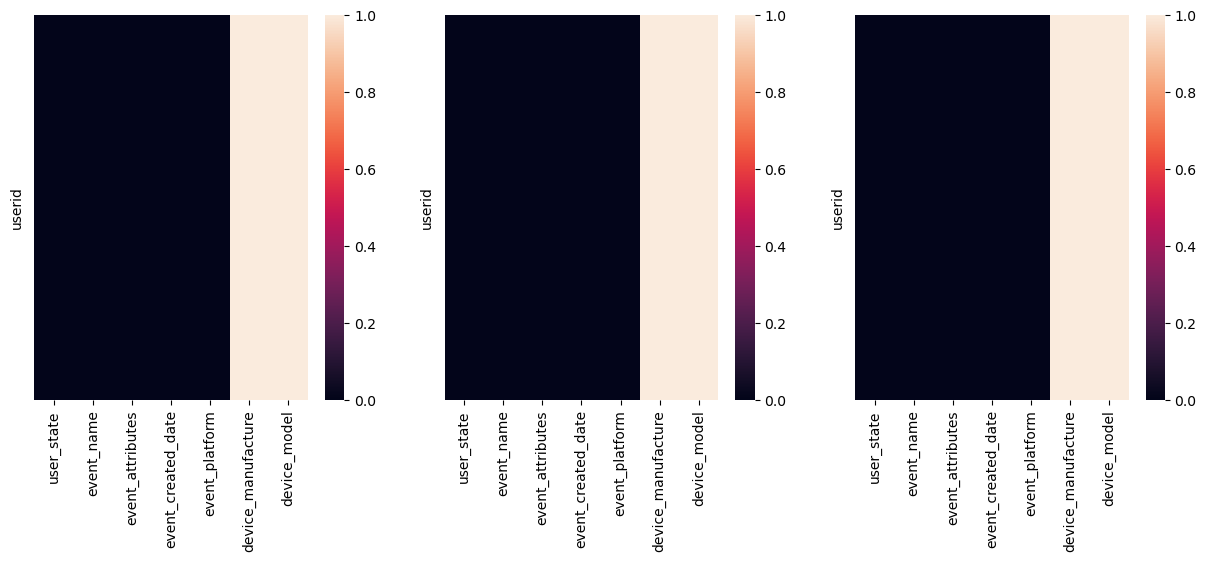

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.heatmap(data[data['event_name'] == 'Subscription Premium'].isna(), ax = axes[0], yticklabels = False)
sns.heatmap(data[data['event_name'] == 'Subscription Premium Renew'].isna(), ax = axes[1], yticklabels = False)
sns.heatmap(data[data['event_name'] == 'Subscription Premium Cancel'].isna(), ax = axes[2], yticklabels = False)

explore some of user with missing data


In [5]:
data.loc['017f4557810b3ba165d2959c17b916b6']

,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
userid,,,,,,,
017f4557810b3ba165d2959c17b916b6,TX,Sign Up Success,"{""Method"":""Email""}",2022-01-17 00:00:47,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Email Confirmation Success,"{""Required"":""true""}",2022-01-17 00:01:19,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Account Setup Skip,{},2022-01-17 00:02:19,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Add Payment Method Success,"{""Tokenized Pay"":""Apple Pay"",""Payment Method"":...",2022-01-17 00:03:44,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Subscription Premium,"{""Start Date"":""2022-01-16"",""Renewal Date"":""202...",2022-01-17 00:04:58,outofband,NaN,NaN
017f4557810b3ba165d2959c17b916b6,TX,Email Confirmation Success,"{""Required"":""true""}",2022-01-17 00:07:55,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Chat Conversation Opened,"{""From"":""Menu""}",2022-01-17 00:08:16,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Add Vehicle Success,"{""Make"":""Honda"",""Model"":""Accord"",""Temporary"":""...",2022-01-17 00:10:45,ios,Apple,"iPhone13,4"
017f4557810b3ba165d2959c17b916b6,TX,Chat Conversation Opened,"{""From"":""Menu""}",2022-01-17 00:15:16,ios,Apple,"iPhone13,4"


seems like event of subcription doesn't fix device of user, so let's replace this values and drop useless device manufacutre and model

In [6]:
data = data.drop(columns = ['device_manufacture', 'device_model'])

In [7]:
tmp = raw.groupby('userid')['event_platform'] \
    .apply(lambda x: x[x!='outofband'].mode()).reset_index().drop(['level_1'], axis='columns')
tmp.dropna(subset=['userid'] + ['event_platform'], inplace=True)
tmp['is_ios'] =tmp['event_platform'].map({'android': 0, 'ios': 1})
data = data.drop(columns = ['event_platform']).merge(tmp, how='inner', on='userid').set_index('userid').drop(['event_platform'], axis='columns')

so we get devices, but how they are distributed?

In [8]:
tmp = data.copy()
tmp = data.groupby('userid')['event_name'].apply(lambda x: Counter(x)).reset_index()
tmp.fillna(0, inplace=True)
tmp = pd.pivot(tmp, index='userid', columns='level_1', values='event_name')
tmp = tmp['Subscription Premium Cancel'] > 0
tmp = data.merge(tmp, how='left', on='userid')
tmp = tmp[tmp['event_name' ] == 'Subscription Premium']

take a fisher test for binary categories

In [9]:
epi = list(Counter(tmp[tmp['is_ios'].astype(bool)]['Subscription Premium Cancel']).values())
epa = list(Counter(tmp[(tmp['is_ios']==0).astype(bool)]['Subscription Premium Cancel']).values())
mtx = [epi, epa]
odd_ratio, p_value = stats.fisher_exact(mtx)
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 1.1885659589279498
p_value is : 0.3130108222672851


<AxesSubplot:xlabel='is_ios'>

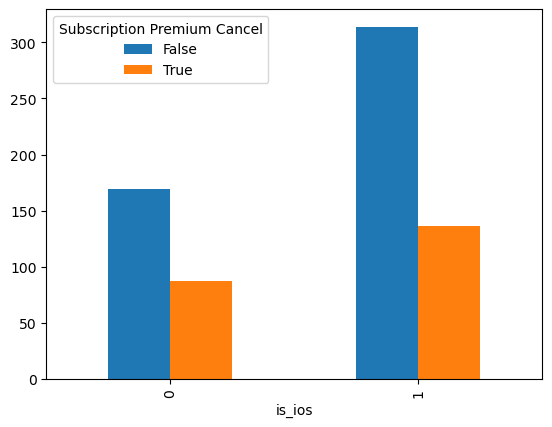

In [10]:
tmp.groupby('is_ios')['Subscription Premium Cancel'].value_counts().unstack().plot(kind='bar')

Yemp, looking for p-value and graph seems like there is no such a difference between android and ios user, it's just proportion

Let's explore distribution of subscriptions by state

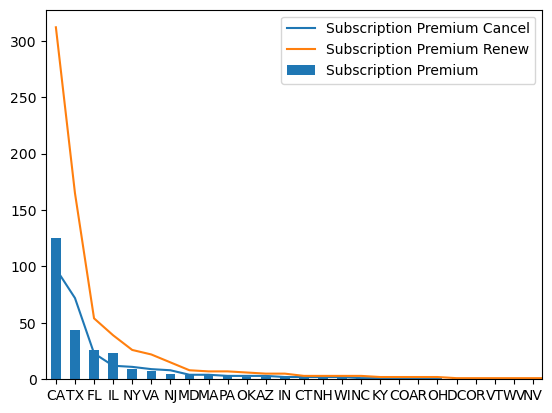

In [11]:
data[data['event_name'] == 'Subscription Premium Cancel']['user_state'].value_counts().plot(kind = 'bar')
data[data['event_name'] == 'Subscription Premium Renew']['user_state'].value_counts().plot()
data[data['event_name'] == 'Subscription Premium']['user_state'].value_counts().plot()
plt.legend(['Subscription Premium Cancel', 'Subscription Premium Renew', 'Subscription Premium'])

Text(0.5, 1.0, 'Premium')

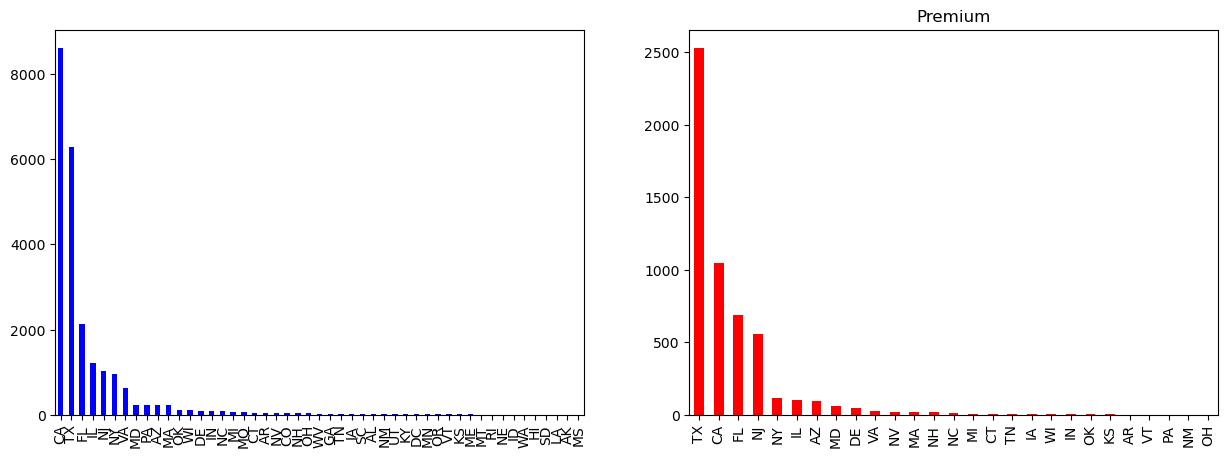

In [12]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
data['user_state'].value_counts().plot(kind = 'bar', label = 'all states', color = 'blue', ax = axes[0])
plt.title('All states')
data[data['event_attributes'].str.contains('"Premium Membership":"True"')]['user_state'].value_counts().plot(kind = 'bar', label = 'Premium Membership', color = 'red', ax = axes[1])
plt.title('Premium')

subscription users are in much less states, so we'll use it while engeneering this feature further

What type of subscription we have?

In [13]:
print('How much users buy monthly subscription',(data[data['event_attributes'].str.contains('"Membership Type":"Monthly"')].index.nunique()))
print('Yearly',(data[data['event_attributes'].str.contains('"Membership Type":"Yearly"')]['event_attributes'].value_counts()).sum())

How much users buy monthly subscription 722
Yearly 91


We should notice, that use which buy monthly sub and year could be same person
let's annotate wich subscription user choose

In [14]:
data['event_name'].unique()

array(['Add Vehicle Success', 'Add Vehicle Break',
       'Add Payment Method Success',
       'Account History Transaction Details', 'Order', 'Calculator View',
       'Subscription Premium Renew', 'Sign Up Success',
       'Add Payment Method Failed', 'Wallet Opened',
       'Email Confirmation Success', 'Account Setup Skip',
       'Subscription Premium', 'Chat Conversation Opened',
       'Chat Conversation Started', 'Account Setup Profile Skip',
       'Sign Out', 'Subscription Premium Cancel', 'Calculator Used',
       'Transaction Refund', 'Sign Up Error', 'Add Vehicle Failed',
       'Reset Password Set'], dtype=object)

based of having events we can divide them into groups to help model understand which issues with service user had


 - calculator activity:
'Calculator View', 'Calculator Used'

 - operations with money:
'Account History Transaction Details' 'Wallet Opened'  

 - refund:
'Transaction Refund'

 - asked for help:
'Chat Conversation Opened' 'Chat Conversation Started' 

 - oreder:
'Order'

 - have vehicle errors:
 'Add Vehicle Failed', 'Add Vehicle Break'
 
 - have account errors:
'Add Payment Method Failed', 'Sign Up Error' 

- buy subscription:
'Subscription Premium', 'Subscription Premium Renew'

- canceled subscription:
'Subscription Premium Cancel'

- other account activity:
'Add Payment Method Success', 'Sign Up Success', 'Email Confirmation Success' 
'Account Setup Skip', 'Account Setup Profile Skip'
'Reset Password Set' 'Sign Out','Add Vehicle Success'

let's explore frequency of events of users with subscription

In [15]:
subscribed = data[data['event_name'] == 'Subscription Premium'].index.to_numpy()

subscribedData = data.loc[subscribed]

subscribedData.event_name.value_counts()

Order                                  4000
Account History Transaction Details    1293
Wallet Opened                          1052
Chat Conversation Opened               1035
Chat Conversation Started               808
Add Vehicle Success                     781
Add Payment Method Success              770
Subscription Premium                    706
Sign Up Success                         681
Calculator View                         365
Subscription Premium Cancel             241
Email Confirmation Success              209
Subscription Premium Renew              199
Sign Out                                175
Add Vehicle Break                       153
Account Setup Profile Skip              111
Add Payment Method Failed                91
Transaction Refund                       87
Calculator Used                          74
Account Setup Skip                       19
Add Vehicle Failed                        5
Sign Up Error                             2
Reset Password Set              

now look at events of people who canceled subscription

In [16]:
subscribedCancel = data[data['event_name'] == 'Subscription Premium Cancel'].index.to_numpy()

subscribedCancelData = data.loc[subscribedCancel]

subscribedCancelData.event_name.value_counts()

Chat Conversation Opened               825
Chat Conversation Started              751
Order                                  727
Account History Transaction Details    617
Wallet Opened                          562
Sign Out                               421
Subscription Premium Cancel            309
Add Payment Method Success             273
Add Vehicle Success                    249
Subscription Premium                   241
Sign Up Success                        236
Calculator View                        148
Transaction Refund                     103
Email Confirmation Success              73
Add Vehicle Break                       59
Account Setup Profile Skip              58
Subscription Premium Renew              44
Add Payment Method Failed               29
Calculator Used                         24
Account Setup Skip                      10
Sign Up Error                            1
Add Vehicle Failed                       1
Name: event_name, dtype: int64

we can say that last our group of trivial operations with account is useless and we can avoid creating this feature for this target, but we'll keep all events in model creation. Also we can union vehicle errors with account's one. It's obvious that user cant cancel subscription if he haven't buy it so this feature will be useless too. So, for our task we can use only users which have subscription.

In [17]:
data['event_name'].apply(lambda x: 1 if x == 'Subscription Premium' else 0).sum()

706

In [18]:
calculator_activity = ['Calculator View', 'Calculator Used']

operations_with_money = ['Account History Transaction Details', 'Wallet Opened']

refund = ['Transaction Refund']

asked_for_help = ['Chat Conversation Opened', 'Chat Conversation Started']

oreder = ['Order']

had_errors = ['Add Vehicle Failed', 'Add Vehicle Break', 'Add Payment Method Failed', 'Sign Up Error']

canceled_subscription = ['Subscription Premium Cancel']

groups = [calculator_activity, operations_with_money, refund, asked_for_help, oreder, had_errors, canceled_subscription]

subscribedWithGroups = subscribedData.copy()

for group in groups:
    ## check is user have event from group, if so, add to data feature named groupd where 1 if user have event neither 0
    for event in group:
        subscribedWithGroups[str(group[0])] = subscribedWithGroups['event_name'].apply(lambda x: 1 if x == str(event) else 0)
          
subscribedWithGroups.columns = ['user_state', 'event_name', 'event_attributes', 'event_created_date',
       'is_ios', 
       'calcActivity', 'moneyCheck',
       'refund', 'chatHelp', 'Order',
       'hadErrors', 'cancelSubscription']

In [19]:
subscribedWithGroups.head()

,user_state,event_name,event_attributes,event_created_date,is_ios,calcActivity,moneyCheck,refund,chatHelp,Order,hadErrors,cancelSubscription
userid,,,,,,,,,,,,
017f4557810b3ba165d2959c17b916b6,TX,Sign Up Success,"{""Method"":""Email""}",2022-01-17 00:00:47,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,TX,Email Confirmation Success,"{""Required"":""true""}",2022-01-17 00:01:19,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,TX,Account Setup Skip,{},2022-01-17 00:02:19,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,TX,Add Payment Method Success,"{""Tokenized Pay"":""Apple Pay"",""Payment Method"":...",2022-01-17 00:03:44,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,TX,Subscription Premium,"{""Start Date"":""2022-01-16"",""Renewal Date"":""202...",2022-01-17 00:04:58,1,0,0,0,0,0,0,0


now let's deal with states using binary encoder as we have a lot of unique values

In [20]:
encoder = ce.BinaryEncoder(cols=['user_state'])
subscribedWithGroups = encoder.fit_transform(subscribedWithGroups)

In [21]:
subscribedWithGroups.head()

,user_state_0,user_state_1,user_state_2,user_state_3,user_state_4,user_state_5,event_name,event_attributes,event_created_date,is_ios,calcActivity,moneyCheck,refund,chatHelp,Order,hadErrors,cancelSubscription
userid,,,,,,,,,,,,,,,,,
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Sign Up Success,"{""Method"":""Email""}",2022-01-17 00:00:47,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Email Confirmation Success,"{""Required"":""true""}",2022-01-17 00:01:19,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Account Setup Skip,{},2022-01-17 00:02:19,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Add Payment Method Success,"{""Tokenized Pay"":""Apple Pay"",""Payment Method"":...",2022-01-17 00:03:44,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Subscription Premium,"{""Start Date"":""2022-01-16"",""Renewal Date"":""202...",2022-01-17 00:04:58,1,0,0,0,0,0,0,0


actually, we can check general correlation of events to canceling already, lezdoit!

<AxesSubplot:>

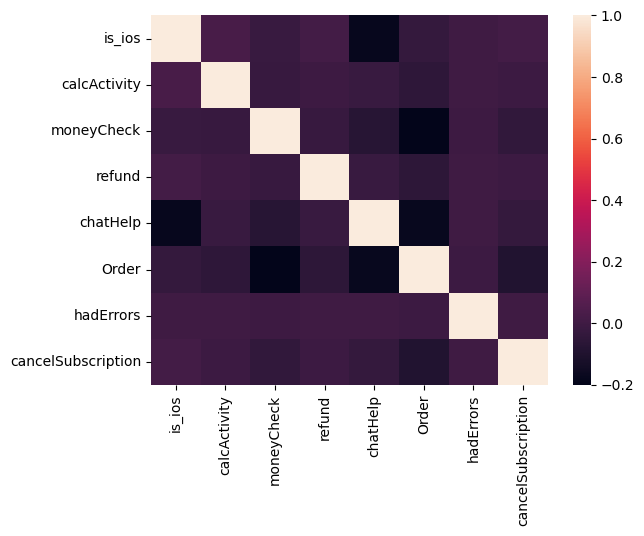

In [22]:
sns.heatmap(subscribedWithGroups[['event_name', 'event_attributes', 'is_ios',
       'event_created_date', 'calcActivity', 'moneyCheck', 'refund', 'chatHelp',
       'Order', 'hadErrors', 'cancelSubscription']].corr())

uff, seems like it ain't easy to detect, let's look at list, but seems like andriod users have more support questions

In [23]:
subscribedWithGroups[['event_name', 'event_attributes', 'is_ios',
       'event_created_date', 'calcActivity', 'moneyCheck', 'refund', 'chatHelp',
       'Order', 'hadErrors', 'cancelSubscription']].corr()['cancelSubscription'].sort_values(ascending=True)

Order                -0.092874
moneyCheck           -0.041256
chatHelp             -0.035788
refund               -0.011407
calcActivity         -0.010515
hadErrors            -0.001724
is_ios                0.013711
cancelSubscription    1.000000
Name: cancelSubscription, dtype: float64

sheeesh, platform has a big impact! and looks like order is has a big impact, but it's obvious because purchase of sub is also order, so for us most valuable is does user care a lot about money he spent and is user asked for support

what useful we can get from event attributes?

In [24]:
useless_attr =  ['{}', '{"From":"Menu"}', '{"Premium Membership":"True"}', '{"Method":"Apple"}', '{"Method":"Google"}', '{"Method":"Facebook"}', '{"Required":"true"} ']
print('Most of popular attributes:')
subscribedWithGroups[[ext not in useless_attr for ext in subscribedWithGroups['event_attributes']]]['event_attributes'].value_counts()[:50]

Most of popular attributes:


{"Type":"Auto Payment","Navigated From":"account_history"}                                                                                289
{"From":"Menu","Transaction type":""}                                                                                                     207
{"Method":"Email"}                                                                                                                        182
{"Navigated From":"Account History","Status":"Paid","Type":"Pro Plan Subscription"}                                                       169
{"Type":"Pro Plan Subscription","Navigated From":"account_history","Status":"Paid"}                                                       167
{"Navigated From":"Account History","Status":"Pending","Type":"Auto Payment"}                                                             160
{"Required":"true"}                                                                                                                       147
{"Type

I don't see something really usefull :(

In [25]:
subscribedWithGroups.drop(columns = ['event_attributes'], inplace = True)

In [26]:
subscribedWithGroups.head(10)

,user_state_0,user_state_1,user_state_2,user_state_3,user_state_4,user_state_5,event_name,event_created_date,is_ios,calcActivity,moneyCheck,refund,chatHelp,Order,hadErrors,cancelSubscription
userid,,,,,,,,,,,,,,,,
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Sign Up Success,2022-01-17 00:00:47,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Email Confirmation Success,2022-01-17 00:01:19,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Account Setup Skip,2022-01-17 00:02:19,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Add Payment Method Success,2022-01-17 00:03:44,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Subscription Premium,2022-01-17 00:04:58,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Email Confirmation Success,2022-01-17 00:07:55,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Chat Conversation Opened,2022-01-17 00:08:16,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Add Vehicle Success,2022-01-17 00:10:45,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Chat Conversation Opened,2022-01-17 00:15:16,1,0,0,0,0,0,0,0


It might be usefull, if we extract only events, which user make while having a subscription

In [27]:
tempdate = subscribedWithGroups.copy()

tempdate['subDate'] = subscribedWithGroups[subscribedWithGroups['event_name'] == 'Subscription Premium']['event_created_date']
tempdate['endDate'] = tempdate.groupby('userid').last()['event_created_date']
cancelDateidx = tempdate[tempdate['event_name'] == 'Subscription Premium Cancel']['event_created_date'].index
cancelDate = tempdate[tempdate['event_name'] == 'Subscription Premium Cancel']['event_created_date'].to_numpy()
for idx, val in zip(cancelDateidx, cancelDate):
    tempdate.loc[idx,'endDate'] = val

tempdate.reset_index(inplace = True)

In [28]:
print(tempdate.shape)
for row in tempdate.itertuples():
    if row.event_created_date > row.endDate or row.event_created_date < row.subDate:
        tempdate.drop(row.Index, inplace=True)
    
print(tempdate.shape)

(12858, 19)
(9435, 19)


In [29]:
subscribedWithGroups = tempdate.set_index('userid').drop(columns = ['event_created_date', 'subDate', 'endDate'])

In [30]:
subscribedWithGroups.head()

,user_state_0,user_state_1,user_state_2,user_state_3,user_state_4,user_state_5,event_name,is_ios,calcActivity,moneyCheck,refund,chatHelp,Order,hadErrors,cancelSubscription
userid,,,,,,,,,,,,,,,
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Subscription Premium,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Email Confirmation Success,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Chat Conversation Opened,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Add Vehicle Success,1,0,0,0,0,0,0,0
017f4557810b3ba165d2959c17b916b6,0,0,0,0,0,1,Chat Conversation Opened,1,0,0,0,0,0,0,0


We've cleaned a lot of data for now! At this point we can make a model which will explain feature importance more precisely

 :)